# 第 14 章 SAC 算法

## 14.1 简介

之前的章节提到过在线策略算法的采样效率比较低，我们通常更倾向于使用离线策略算法。然而，虽然 DDPG 是离线策略算法，但是它的训练非常不稳定，收敛性较差，对超参数比较敏感，也难以适应不同的复杂环境。2018 年，一个更加稳定的离线策略算法 Soft Actor-Critic（SAC）被提出。SAC 的前身是 Soft Q-learning，它们都属于最大熵强化学习的范畴。Soft Q-learning 不存在一个显式的策略函数，而是使用一个函数 $Q$ 的波尔兹曼分布，在连续空间下求解非常麻烦。于是 SAC 提出使用一个 Actor 表示策略函数，从而解决这个问题。目前，在无模型的强化学习算法中，SAC 是一个非常高效的算法，它学习一个随机性策略，在不少标准环境中取得了领先的成绩。

## 14.2 最大熵强化学习

熵（entropy）表示对一个随机变量的随机程度的度量。

在强化学习中，我们可以使用 $H(\pi(\dot|s))$ 来表示策略在状态下的随机程度。

最大熵强化学习（maximum entropy RL）的思想就是除了要最大化累积奖励，还要使得策略更加随机。如此，强化学习的目标中就加入了一项熵的正则项

熵正则化增加了强化学习算法的探索程度，越大，探索性就越强，有助于加速后续的策略学习，并减少策略陷入较差的局部最优的可能性。

## 14.3 Soft 策略迭代

在最大熵强化学习框架中，由于目标函数发生了变化，其他的一些定义也有相应的变化。

## 14.4 SAC

在 SAC 算法中，我们为两个动作价值函数$Q$（参数分别为$\omega_1$和$\omega_2$）和一个策略函数$\pi$（参数为$\theta$）建模。基于 Double DQN 的思想，SAC 使用两个$Q$网络，但每次用$Q$网络时会挑选一个$Q$值小的网络，从而缓解$Q$值过高估计的问题。

### 自动调整熵正则项

在 SAC 算法中，如何选择熵正则项的系数非常重要。在不同的状态下需要不同大小的熵：在最优动作不确定的某个状态下，熵的取值应该大一点；而在某个最优动作比较确定的状态下，熵的取值可以小一点。为了自动调整熵正则项，SAC 将强化学习的目标改写为一个带约束的优化问题：

## 14.5 SAC 代码实践

我们来看一下 SAC 的代码实现，首先在倒立摆环境下进行实验，然后再尝试将 SAC 应用到与离散动作交互的车杆环境。

首先我们导入需要用到的库。

In [1]:
import random
import gym
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import rl_utils

接下来定义策略网络和价值网络。由于处理的是与连续动作交互的环境，策略网络输出一个高斯分布的均值和标准差来表示动作分布；而价值网络的输入是状态和动作的拼接向量，输出一个实数来表示动作价值。

In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)
        self.action_bound = action_bound

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        dist = Normal(mu, std)
        normal_sample = dist.rsample()  # rsample()是重参数化采样
        log_prob = dist.log_prob(normal_sample)
        action = torch.tanh(normal_sample)
        # 计算tanh_normal分布的对数概率密度
        log_prob = log_prob - torch.log(1 - torch.tanh(action).pow(2) + 1e-7)
        action = action * self.action_bound
        return action, log_prob


class QValueNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QValueNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, a):
        cat = torch.cat([x, a], dim=1)
        x = F.relu(self.fc1(cat))
        x = F.relu(self.fc2(x))
        return self.fc_out(x)

然后我们来看一下 SAC 算法的主要代码。

如 14.4 节所述，SAC 使用两个 Critic 网络

In [3]:
class SACContinuous:
    ''' 处理连续动作的SAC算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, action_bound,
                 actor_lr, critic_lr, alpha_lr, target_entropy, tau, gamma,
                 device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim,
                                         action_bound).to(device)  # 策略网络
        self.critic_1 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第一个Q网络
        self.critic_2 = QValueNetContinuous(state_dim, hidden_dim,
                                            action_dim).to(device)  # 第二个Q网络
        self.target_critic_1 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第一个目标Q网络
        self.target_critic_2 = QValueNetContinuous(state_dim,
                                                   hidden_dim, action_dim).to(
                                                       device)  # 第二个目标Q网络
        # 令目标Q网络的初始参数和Q网络一样
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_1_optimizer = torch.optim.Adam(self.critic_1.parameters(),
                                                   lr=critic_lr)
        self.critic_2_optimizer = torch.optim.Adam(self.critic_2.parameters(),
                                                   lr=critic_lr)
        # 使用alpha的log值,可以使训练结果比较稳定
        self.log_alpha = torch.tensor(np.log(0.01), dtype=torch.float)
        self.log_alpha.requires_grad = True  # 可以对alpha求梯度
        self.log_alpha_optimizer = torch.optim.Adam([self.log_alpha],
                                                    lr=alpha_lr)
        self.target_entropy = target_entropy  # 目标熵的大小
        self.gamma = gamma
        self.tau = tau
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        action = self.actor(state)[0]
        return [action.item()]

    def calc_target(self, rewards, next_states, dones):  # 计算目标Q值
        next_actions, log_prob = self.actor(next_states)
        entropy = -log_prob
        q1_value = self.target_critic_1(next_states, next_actions)
        q2_value = self.target_critic_2(next_states, next_actions)
        next_value = torch.min(q1_value,
                               q2_value) + self.log_alpha.exp() * entropy
        td_target = rewards + self.gamma * next_value * (1 - dones)
        return td_target

    def soft_update(self, net, target_net):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) +
                                    param.data * self.tau)

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        # 和之前章节一样,对倒立摆环境的奖励进行重塑以便训练
        rewards = (rewards + 8.0) / 8.0

        # 更新两个Q网络
        td_target = self.calc_target(rewards, next_states, dones)
        critic_1_loss = torch.mean(
            F.mse_loss(self.critic_1(states, actions), td_target.detach()))
        critic_2_loss = torch.mean(
            F.mse_loss(self.critic_2(states, actions), td_target.detach()))
        self.critic_1_optimizer.zero_grad()
        critic_1_loss.backward()
        self.critic_1_optimizer.step()
        self.critic_2_optimizer.zero_grad()
        critic_2_loss.backward()
        self.critic_2_optimizer.step()

        # 更新策略网络
        new_actions, log_prob = self.actor(states)
        entropy = -log_prob
        q1_value = self.critic_1(states, new_actions)
        q2_value = self.critic_2(states, new_actions)
        actor_loss = torch.mean(-self.log_alpha.exp() * entropy -
                                torch.min(q1_value, q2_value))
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # 更新alpha值
        alpha_loss = torch.mean(
            (entropy - self.target_entropy).detach() * self.log_alpha.exp())
        self.log_alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()

        self.soft_update(self.critic_1, self.target_critic_1)
        self.soft_update(self.critic_2, self.target_critic_2)

接下来我们就在倒立摆环境上尝试一下 SAC 算法吧！

In [4]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]  # 动作最大值
random.seed(0)
np.random.seed(0)
env.seed(0)
torch.manual_seed(0)

actor_lr = 3e-4
critic_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005  # 软更新参数
buffer_size = 100000
minimal_size = 1000
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = SACContinuous(state_dim, hidden_dim, action_dim, action_bound,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = rl_utils.train_off_policy_agent(env, agent, num_episodes,
                                              replay_buffer, minimal_size,
                                              batch_size)

/home/yubuntust/miniconda3/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/yubuntust/miniconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/yubuntust/miniconda3/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 0:   0%|                                       | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_691917/2202922912.py:38: User

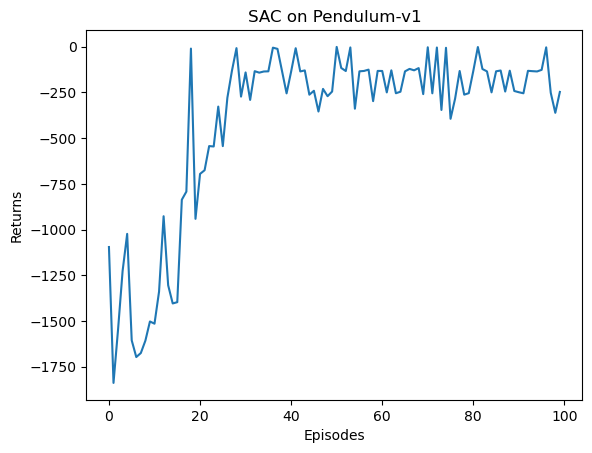

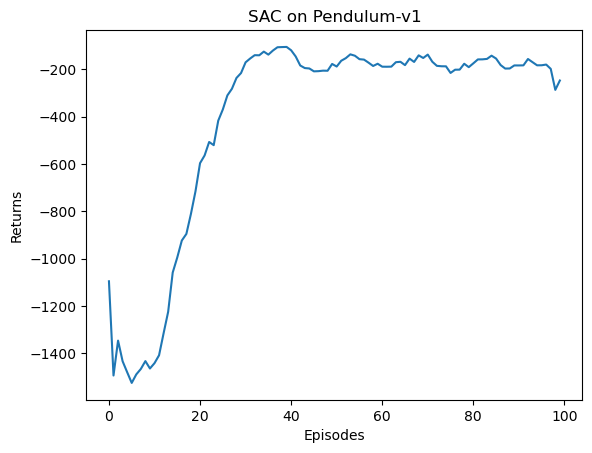

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()